# Кейс - HR аналитика

## Первая часть задачи

### Описание

#### Описание задачи

**Прогнозирование уровня удовлетворенности сотрудников**

* Цель: Разработать модель машинного обучения для предсказания уровня удовлетворенности сотрудника работой на основе доступных характеристик персонала.

* Постановка задачи: Построить регрессионную модель, которая на входе принимает набор признаков сотрудника (демографические данные, характеристики работы, показатели производительности и т.д.), а на выходе предсказывает числовое значение удовлетворенности в диапазоне от 0 до 1, где 0 соответствует полной неудовлетворенности, а 1 — максимальной удовлетворенности работой.

* Бизнес-ценность: Автоматизация процесса оценки удовлетворенности персонала позволит HR-службе оперативно выявлять сотрудников с низким уровнем удовлетворенности без проведения массовых опросов, что существенно сократит время и ресурсы на сбор обратной связи от персонала.

#### Описание данных

**Общая характеристика датасета**

Датасет содержит информацию о сотрудниках компании «Работа с заботой» и включает в себя демографические, профессиональные и оценочные характеристики персонала. Данные представлены в формате CSV и разделены на тренировочную и тестовую выборки для решения задач регрессии и классификации.

**Структура данных**

- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Тестовая выборка: разделена на признаки (`test_features.csv`) и целевую переменную (`test_target_job_satisfaction_rate.csv`)

**Описание признаков**

| Признак | Описание |
|---------|----------|
| `id` | Уникальный идентификатор сотрудника |
| `dept` | Департамент/отдел, в котором работает сотрудник |
| `level` | Уровень занимаемой должности в иерархии компании |
| `workload` | Уровень рабочей загруженности сотрудника |
| `employment_years` | Стаж работы в компании (количество полных лет) |
| `last_year_promo` | Индикатор получения повышения в течение последнего года |
| `last_year_violations` | Индикатор нарушений трудового договора в течение последнего года |
| `supervisor_evaluation` | Оценка производительности сотрудника руководителем |
| `salary` | Размер ежемесячной заработной платы |
| `job_satisfaction_rate` | Уровень удовлетворенности работой (диапазон: 0-1) - целевая переменная |

**Целевая переменная**

**`job_satisfaction_rate`** — непрерывная переменная, представляющая уровень удовлетворенности сотрудника работой, измеренная на основе результатов внутренних опросов обратной связи. Значения нормализованы в диапазоне [0, 1], где:
- 0 — полная неудовлетворенность работой
- 1 — максимальная удовлетворенность работой

### Подготовка к работе

#### Установка и импорт необходимых библиотек

In [1]:
# Установка библиотек
!pip install shap -q
!pip install phik -q
!pip install --upgrade scikit-learn -q

In [2]:
# Базовые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import math

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn: модели и инструменты
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer

# Преобразование признаков
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder,
    OrdinalEncoder, LabelEncoder
)
from sklearn.preprocessing import FunctionTransformer

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# PHIK корреляция
from phik import phik_matrix
import phik

#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### Загрузка датфреймов и общая информация о них

In [3]:
train_jsr = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_jsr.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
test_features_jsr = pd.read_csv('/datasets/test_features.csv')
test_features_jsr.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
test_features_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
test_target_jsr = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_jsr.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
test_target_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


#### Выводы по разделу

**Загрузка и первичный анализ данных**
* Обучающая выборка (train_jsr)
 - Содержит 4000 записей и 10 признаков, включая целевой признак job_satisfaction_rate.
 - Пропущенные значения есть в колонках dept (6 пропусков) и level (4 пропуска).
 - Преобладают категориальные признаки (dept, level, workload, last_year_promo, last_year_violations), а также числовые признаки (employment_years, supervisor_evaluation, salary).

* Тестовая выборка (test_features_jsr)
 - Содержит 2000 записей и 9 признаков (без целевой переменной).
 - Также имеются незначительные пропуски в колонках dept (2 пропуска) и level (1 пропуск).

* Целевая переменная для теста (test_target_jsr)
 - Содержит 2000 записей и состоит из id и job_satisfaction_rate.

**Общий вывод**
Данные структурированы корректно, но содержат незначительные пропуски, которые необходимо обработать перед обучением модели. В датасетах сбалансировано представлены как категориальные, так и числовые признаки, что создаёт основу для построения качественной модели регрессии.

### Предобработка данных

#### Имена столбцов

In [9]:
train_jsr.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [10]:
test_features_jsr.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [11]:
test_target_jsr.columns

Index(['id', 'job_satisfaction_rate'], dtype='object')

Все имена столбцов в датафреймах оформлены корректно и в редактировании не нуждаются

#### Приведение типов

In [12]:
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [13]:
train_jsr.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76


In [14]:
test_features_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [15]:
test_target_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Тут есть признаки last_year_promo и last_year_violations, которые можно закодировать, но мы сделаем это в дальнейшем, на этапе подготовки данных с помощью пайплайна. Все остальные признаки соответсвуют своим типам

#### Обработка пропусков

На данном этапе выявим пропуски, дальнейшее их заполнение будем производить с помощью SimpliImputer на этапе подготовки данных

In [16]:
train_jsr.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [17]:
for col in train_jsr.iloc[:, 1:8]:
    print(col, train_jsr[col].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
employment_years [ 2  1  4  7  9  6  3 10  8  5]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [1 5 2 3 4]


In [18]:
test_features_jsr.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [19]:
for col in test_features_jsr.iloc[:, 1:8]:
    print(col, test_features_jsr[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]


В данном датафрейме помимо обычных nan значений мы наткнулись на пропуск в виде пробела. Нам необходимо заменить его на nan для дальнейшей обработки

In [20]:
for col in test_features_jsr.iloc[:, 1:8]:
    print(col, test_features_jsr[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]


In [21]:
test_target_jsr.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

#### Обработка явных дубликатов

In [22]:
train_jsr.duplicated().sum()

0

In [23]:
test_features_jsr.duplicated().sum()

0

In [24]:
test_target_jsr.duplicated().sum()

0

Мы выяснили, что у нас нет полных дубликатов. Обрабатывать нечего

#### Обработка неявных дубликатов

В данном разделе повторно обратимся к уникальным значениям из каждого из столбцов, а также проверим повторения id в таблице (повторяющегося анкетирования сотрудников по логике быть не должно)

In [25]:
print('Unique values in file train_jsr')
for col in train_jsr.iloc[:, 1:8]:
    print(col, train_jsr[col].unique())
    
print('\nUnique values in file test_features_jsr')
for col in test_features_jsr.iloc[:, 1:8]:
    print(col, test_features_jsr[col].unique())

Unique values in file train_jsr
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
employment_years [ 2  1  4  7  9  6  3 10  8  5]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [1 5 2 3 4]

Unique values in file test_features_jsr
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]


Неявных дубликатов в значениях нет, теперь проверим повторяющихся сотрудников

In [26]:
duplicate_id = train_jsr[train_jsr.duplicated(['id'])]

print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [27]:
duplicate_id = test_features_jsr[test_features_jsr.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []


In [28]:
duplicate_id = test_target_jsr[test_target_jsr.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, job_satisfaction_rate]
Index: []


Повторяющихся сотрудников мы также не обнаружили

#### Проверка и обработка аномалий

Для проверки и обработки аномалий получим распределения количественных признаков в датафреймах

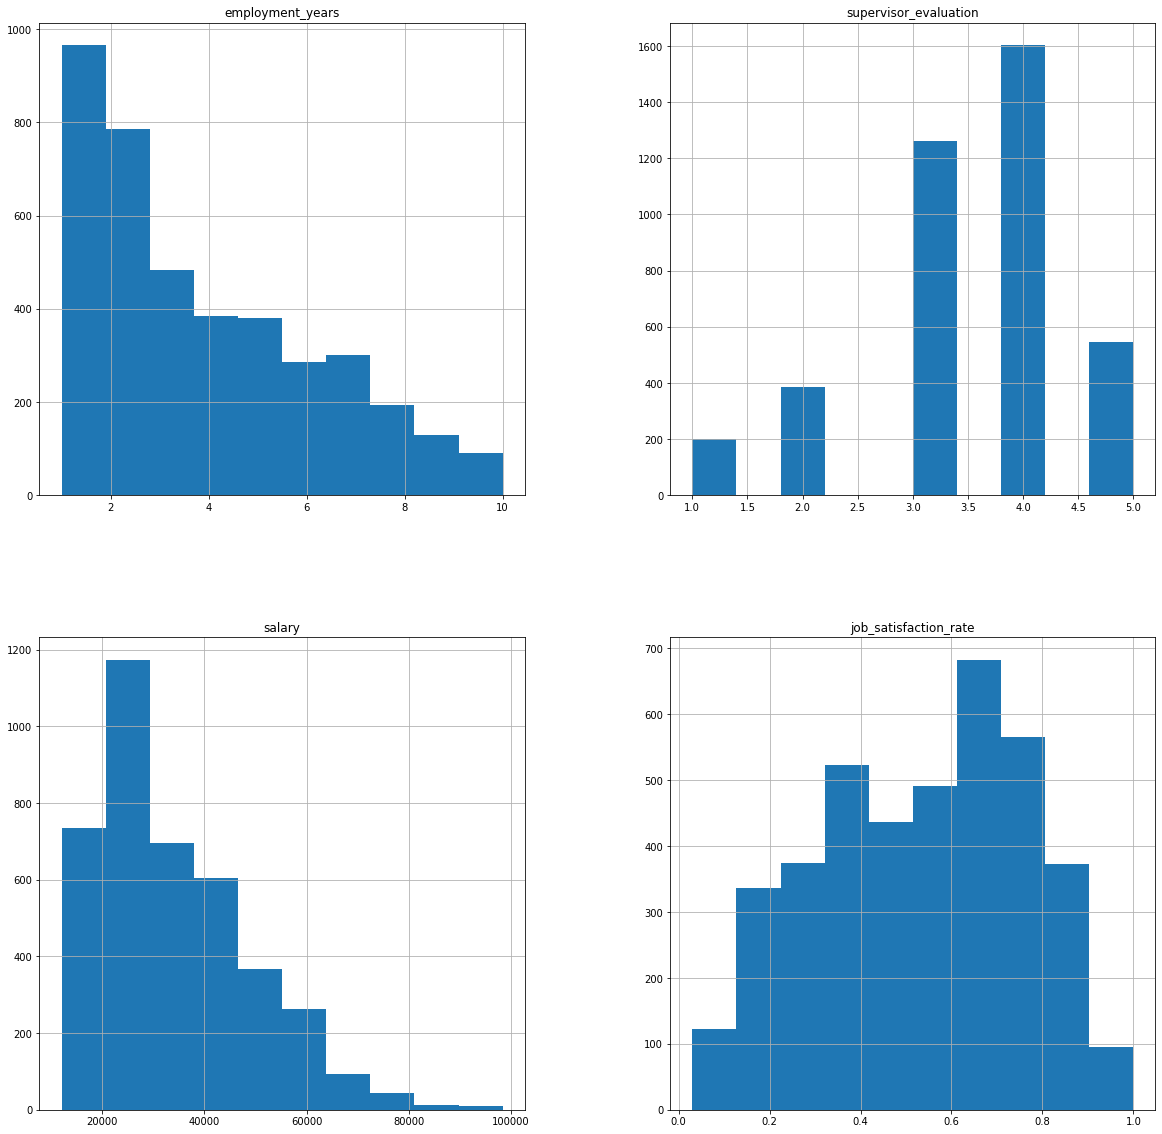

In [29]:
train_jsr.drop('id', axis = 1).hist(figsize = (20,20))
plt.show()

По данным графикам мы можем пронаблюдать отсутствие аномалий. Можно лишь выделить, что оценка от супервайзера и длительность работы - количественные дискретные признаки. При анализе лучше рассматривать их как категории, но при обучении модели масштабировать. Такой вывод получается из их дискретности и количества вариантов меньше 20.

Дальнейший анализ будет проводиться в пункте ниже

#### Выводы по разделу

**Общая характеристика**
Проанализированы датафреймы: тренировочная выборка (4000 записей), тестовая выборка признаков (2000 записей) и целевых значений (2000 записей).

**Выводы**

* Качество данных
 - Имена столбцов корректны, типы данных соответствуют содержимому
 - Дубликаты и повторяющиеся ID отсутствуют
 - Минимальное количество пропусков: `dept` (6-2 пропуска), `level` (4-1 пропуск), `workload` (пробелы заменены на NaN)

**Особенности признаков**

**Количественные:**
- `salary`
- `job_satisfaction_rate`

**Количесвтенные дискретные**
- `employment_years`
- `supervisor_evaluation`

**Категориальные:**
- `last_year_promo`, `last_year_violations`
- `dept`, `level`, `workload`

**Дальнейшие шаги**
1. Использовать SimpleImputer для заполнения пропусков
2. Кодировать категориальные и бинарные признаки
3. Исключить `id` из моделирования

Датасет высокого качества с пропусками менее 1%. Готов для моделирования после стандартной предобработки в пайплайне.

### Исследовательский анализ данных

Для начала реализуем функции для построения графиков

In [30]:
def hist_and_boxplot(df, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Гистограмма
    sns.histplot(df[col_name], ax=axes[0])
    axes[0].set_title(f'Гистограмма: {col_name}')
    axes[0].set_xlabel(f'Значения "{col_name}"')
    axes[0].set_ylabel('Частота')

    # Диаграмма размаха
    sns.boxplot(x=df[col_name], ax=axes[1])
    axes[1].set_title(f'Диаграмма размаха: {col_name}')
    axes[1].set_xlabel(f'Значения "{col_name}"')

    plt.tight_layout()
    plt.show()
    
def pie(dataset, column, x, y, i):
    plt.subplot(x, y, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)['id'].count(),
            startangle=90,
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)['id'].count().index)

#### Количественные признаки

##### train_jsr

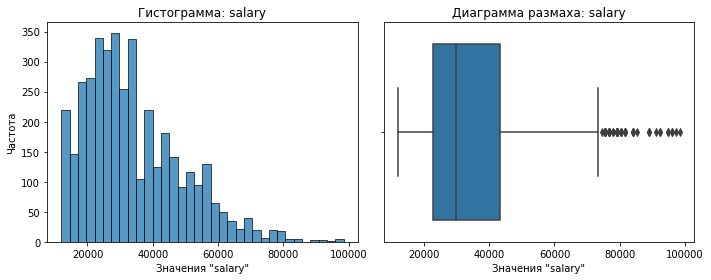

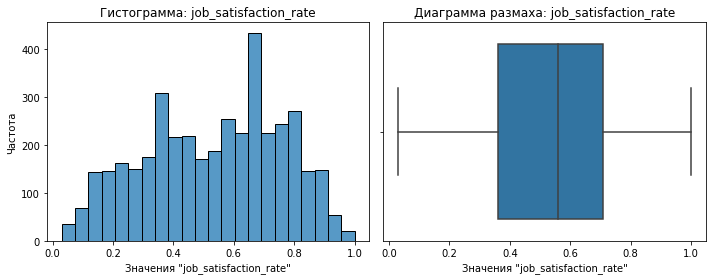

In [31]:
cat_col = ['employment_years','dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
num_col = ['salary']
target = 'job_satisfaction_rate'

for cols in num_col:
    hist_and_boxplot(train_jsr, cols)
hist_and_boxplot(train_jsr, target)

1. salary
 * Распределение: Смещено влево, длинный правый хвост.
 * Вывод: Зарплаты большинства сотрудников находятся в нижнем диапазоне (до 40–50 тыс.). Это характерное логнормальное или экспоненциальное распределение, что типично для доходов. Распределение не нормальное.

2. job_satisfaction_rate
 * Распределение: Бимодальное, по общим чертам похоже на нормальное, но по сути ближе к равномерному.
 * Вывод: Удовлетворённость разнообразна, но с небольшим уклоном в положительную сторону. Возможно, шкала восприятия не линейна.



##### test_features_jsr

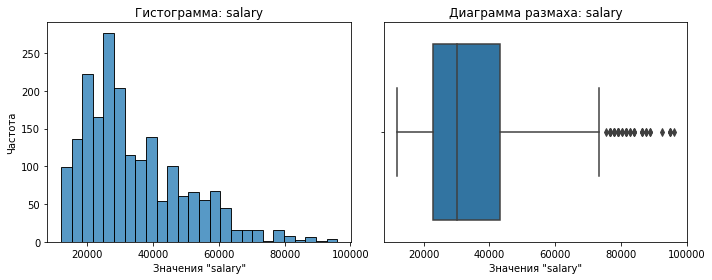

In [32]:
for cols in num_col:
    hist_and_boxplot(test_features_jsr, cols)

Гистограмма:
* Тип: Смещённое влево (положительная асимметрия).
* Характеристика: Больше всего сотрудников получают зарплату в диапазоне 20,000 – 40,000.
* Хвост: Есть длинный правый хвост, свидетельствующий о наличии высоких, но редких значений (высокие зарплаты).
* Форма: Распределение не является нормальным, ближе к логнормальному или экспоненциальному, что типично для доходов.

Диаграмма размаха (boxplot):
* Центральные значения: Медиана ближе к нижнему квартилю — подтверждает смещённость.
* Выбросы: Много значений выше верхней границы — особенно после ~70,000, что подчёркивает разброс доходов в верхнем хвосте.

#### Категориальные признаки

##### train_jsr

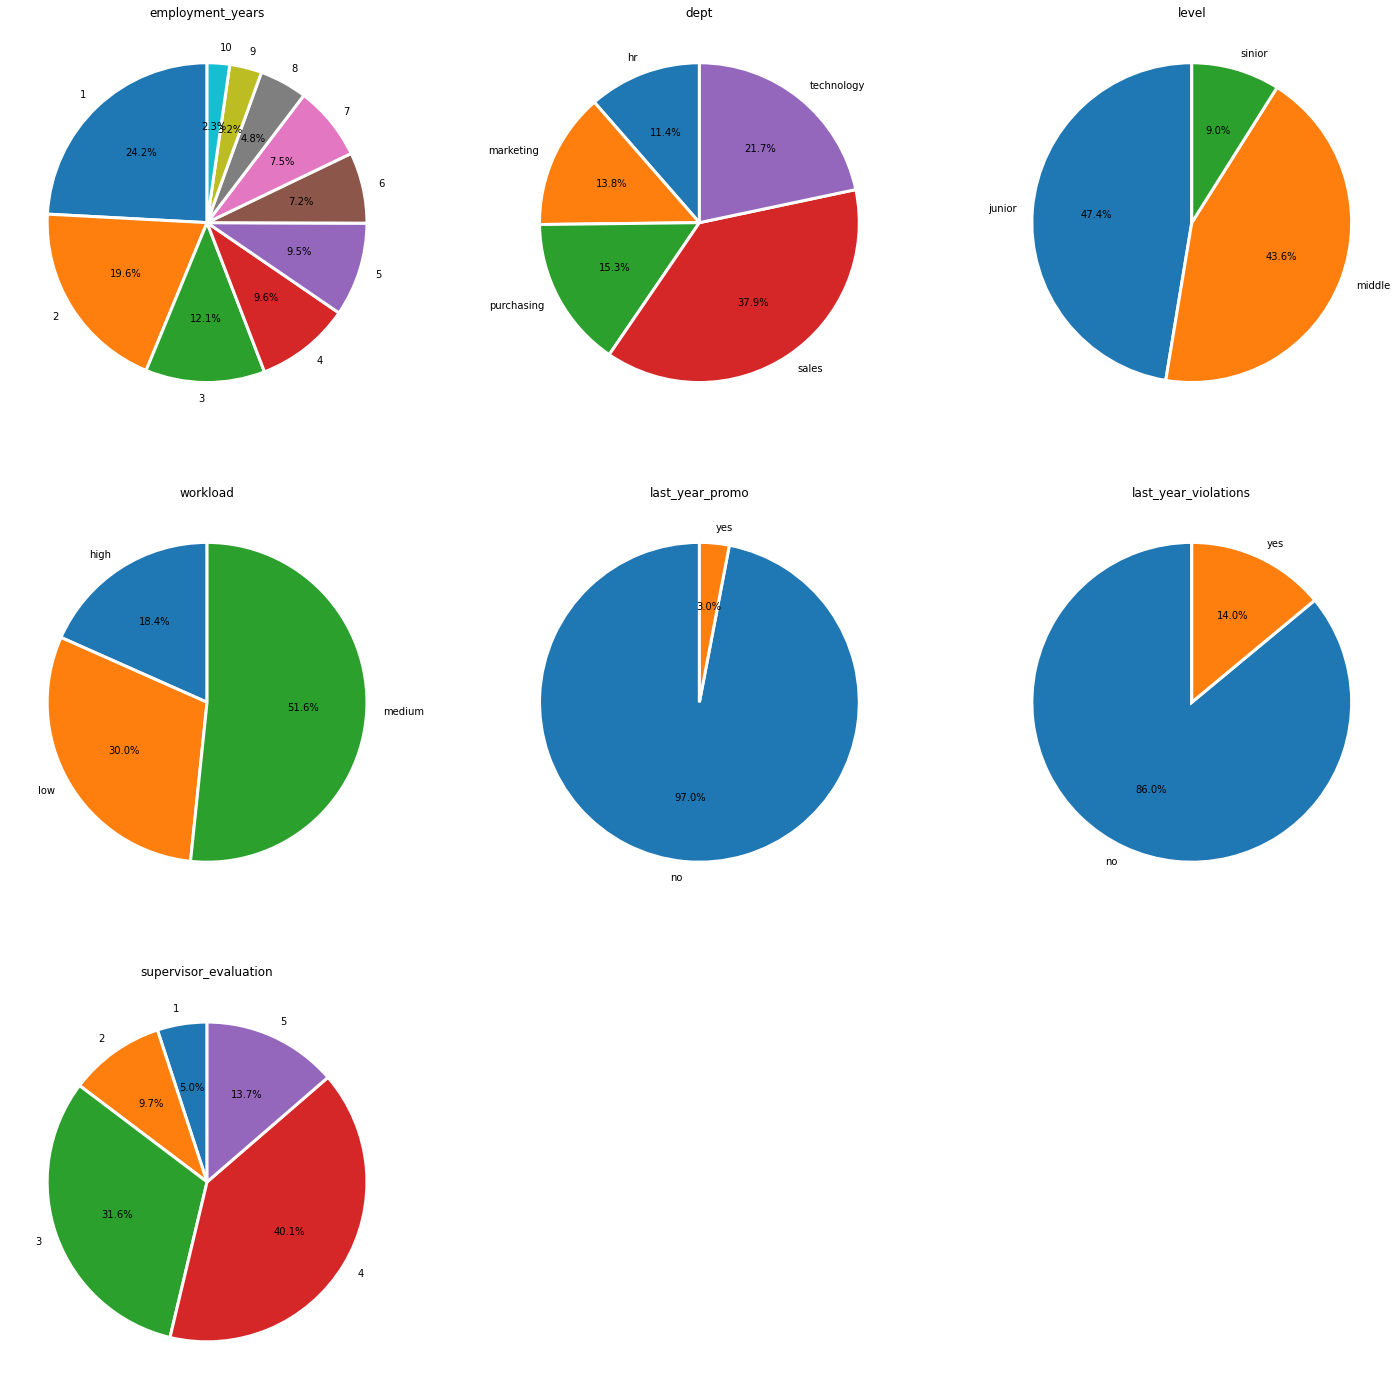

In [33]:
i=1
plt.figure(figsize=(25,25))
for cols in cat_col:
    pie(train_jsr, cols, 3,3, i)
    i+=1

**Выводы по каждой категории**

**Employment Years (Стаж работы)**
- **Преобладание молодых сотрудников**: 24.2% имеют стаж 1 год, 19.6% - 2 года
- **Высокая текучесть кадров**: более 50% сотрудников работают менее 3 лет
- **Опытные сотрудники в меньшинстве**: стаж 7-10 лет составляет менее 10%

**Department (Отдел)**
- **Доминирует продажи**: 37.9% сотрудников в отделе sales
- **Сбалансированное распределение остальных**: technology (21.7%), marketing (13.8%), purchasing (15.3%), hr (11.4%)
- **Потенциальный дисбаланс**: может потребовать стратификации при обучении модели

**Level (Уровень должности)**
- **Преобладание младших специалистов**: 47.4% junior-уровня
- **Пирамидальная структура**: 43.6% middle, только 9.0% senior
- **Типичная корпоративная иерархия**: соответствует ожиданиям

**Workload (Рабочая нагрузка)**
- **Умеренная нагрузка преобладает**: 51.6% medium workload
- **Сбалансированность**: 30.0% low и 38.4% high - относительно равномерное распределение
- **Нормальные условия труда**: отсутствие критических перегрузок

**Last Year Promo (Повышение в прошлом году)**
- **Редкость повышений**: только 3.0% получили повышение
- **Стабильная структура**: 97.0% без изменений в должности
- **Возможная проблема мотивации**: низкий процент карьерного роста

**Last Year Violations (Нарушения в прошлом году)**
- **Дисциплинированный коллектив**: 86.0% без нарушений
- **Умеренный процент нарушителей**: 14.0% имели нарушения
- **Нормальные показатели**: типично для корпоративной среды

**Supervisor Evaluation (Оценка руководителя)**
- **Преобладание высоких оценок**: 40.1% получили оценку 4, 31.6% - оценку 3
- **Позитивный уклон**: 13.7% получили максимальную оценку 5
- **Низкие оценки редки**: только 5% получили оценку 1, 9.7% - оценку 2

**Общие выводы**

**Характеристика организации:**
- **Растущая компания** с высокой долей молодых сотрудников
- **Стабильная рабочая среда** с умеренными нагрузками и редкими нарушениями
- **Ограниченные возможности карьерного роста** (3% повышений)

**Потенциальные проблемы для моделирования:**
- **Дисбаланс классов** в признаках `last_year_promo` и частично `dept`
- **Необходимость учета неравномерного распределения** при валидации модели
- **Возможная корреляция** между `level` и `employment_years`

##### test_features_jsr

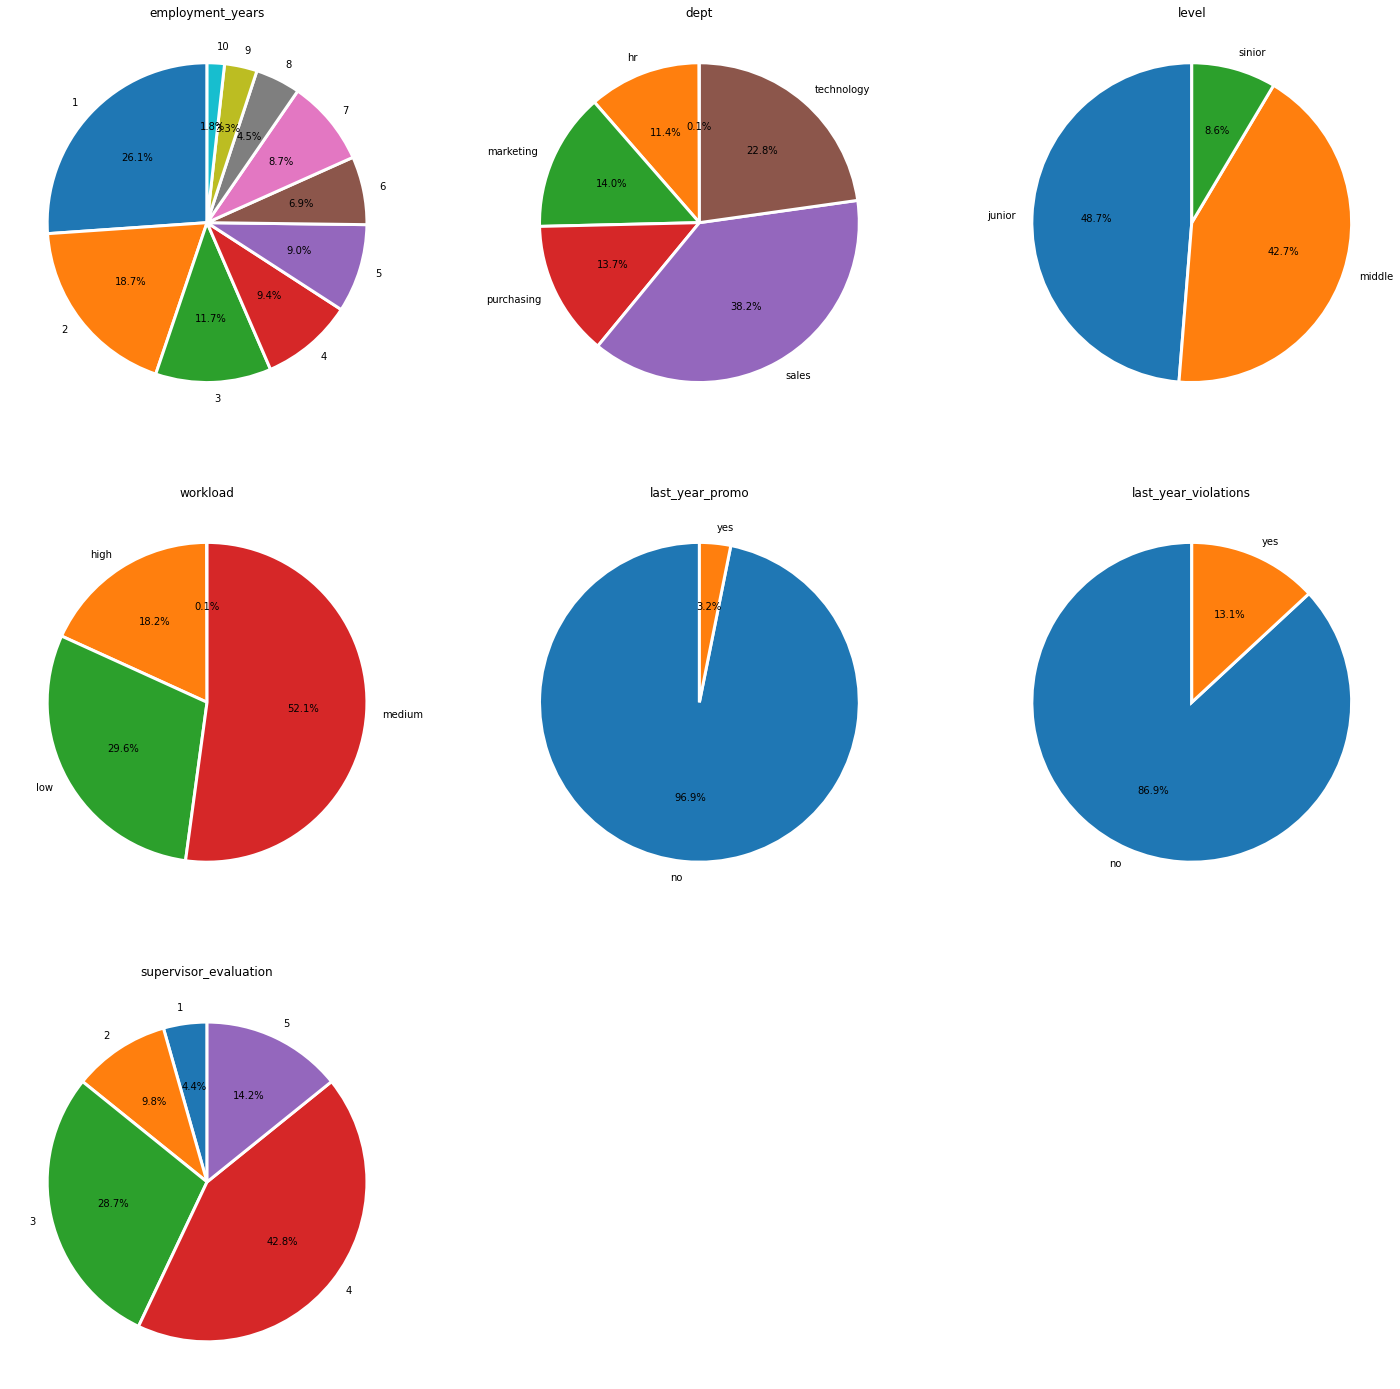

In [34]:
i=1
plt.figure(figsize=(25,25))
for cols in cat_col:
    pie(test_features_jsr, cols, 3,3, i)
    i+=1

**Выводы по каждой категории**

**Employment Years (Стаж работы)**
- **Молодой коллектив**: 26.1% имеют стаж 1 год, 18.7% - 2 года
- **Высокая текучесть**: почти 45% сотрудников работают менее 3 лет
- **Опытные кадры в меньшинстве**: стаж 7-10 лет составляет около 15%

**Department (Отдел)** 
- **Доминирует продажи**: 38.2% сотрудников в отделе sales
- **Равномерное распределение**: technology (22.8%), marketing (14.0%), purchasing (13.7%), hr (11.4%)
- **Сбалансированная структура**: отсутствие критических перекосов

**Level (Уровень должности)**
- **Преобладание junior**: 48.3% младших специалистов
- **Пирамидальная структура**: 42.7% middle, 9.0% senior
- **Классическая иерархия**: соответствует корпоративным стандартам

**Workload (Рабочая нагрузка)**
- **Умеренная нагрузка**: 52.2% medium workload
- **Сбалансированность**: 29.7% low, 18.2% high
- **Комфортные условия**: преобладание умеренной и низкой нагрузки

**Last Year Promo (Повышение в прошлом году)**
- **Крайне редкие повышения**: всего 3.2% получили продвижение
- **Стагнация карьеры**: 96.9% без изменений в должности
- **Критическая проблема**: может влиять на мотивацию

**Last Year Violations (Нарушения в прошлом году)**
- **Высокая дисциплина**: 86.9% без нарушений
- **Умеренные нарушения**: 13.1% имели проблемы
- **Нормальные показатели**: здоровая рабочая атмосфера

**Supervisor Evaluation (Оценка руководителя)**
- **Высокие оценки доминируют**: 42.3% получили оценку 4, 28.7% - оценку 3
- **Позитивные результаты**: 16.2% максимальная оценка 5
- **Редкие низкие оценки**: 4.4% оценка 1, 8.8% оценка 2

**Общие выводы**

**Характеристика организации:**
- Высокая доля молодых сотрудников
- **Стабильная рабочая среда** с умеренными нагрузками и редкими нарушениями
- **Ограниченные возможности карьерного роста** (3% повышений)

**Потенциальные проблемы для моделирования:**
- **Дисбаланс классов** в признаках `last_year_promo` и частично `dept`
- **Необходимость учета неравномерного распределения** при валидации модели
- **Возможная корреляция** между `level` и `employment_years`

#### Проверка корреляции

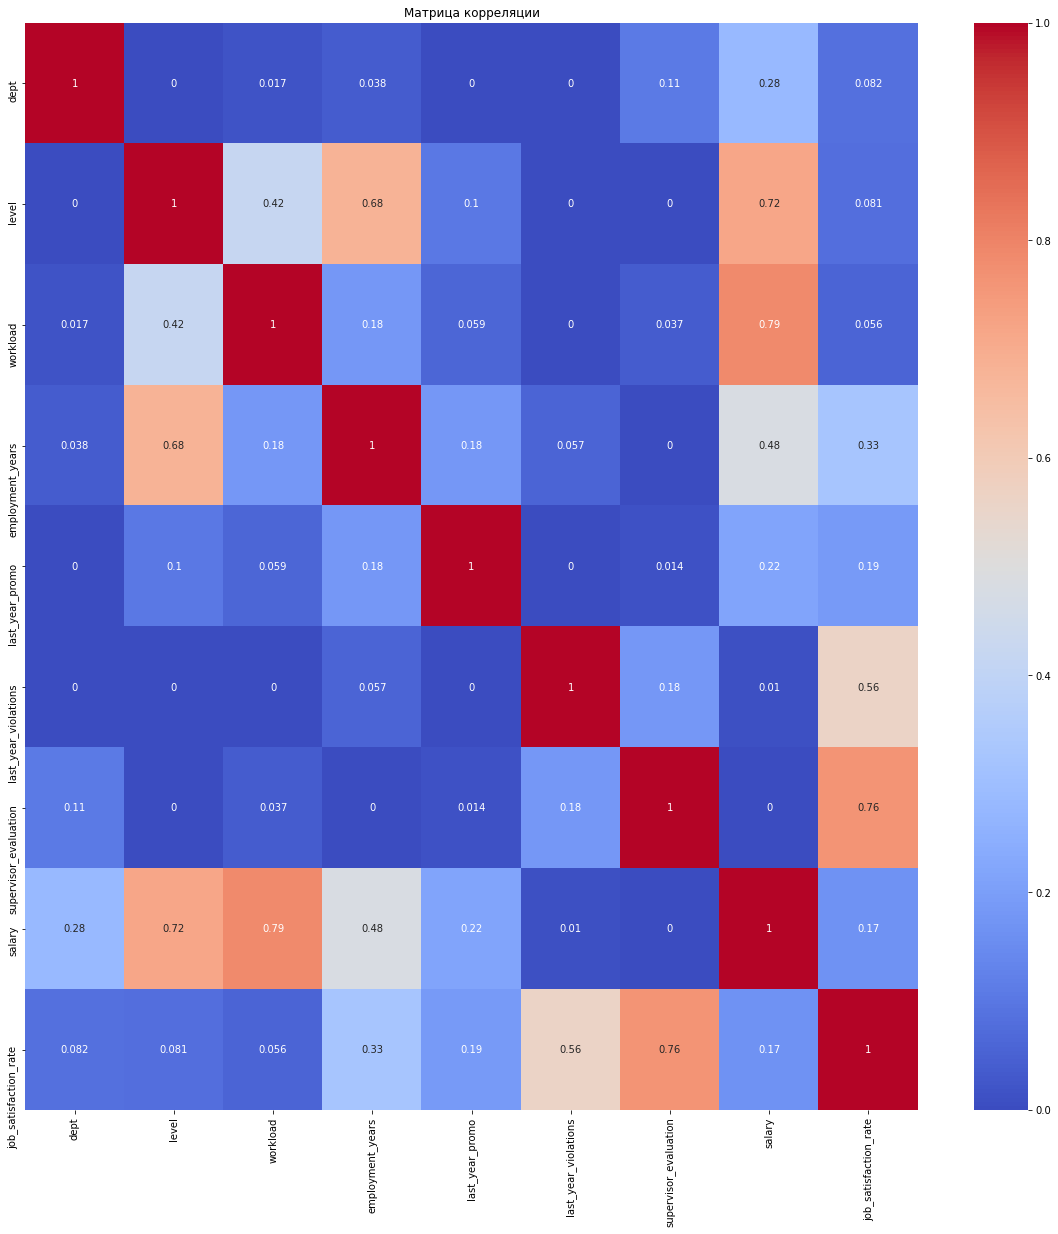

In [35]:
interval_cols = ['salary','job_satisfaction_rate']

corr_matrix = train_jsr.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

**Признаки, наиболее коррелирующих с job_satisfaction_rate:**
1. supervisor_evaluation → 0.76

Очень сильная положительная связь, это логично: чем выше оценка от руководителя, тем выше удовлетворённость работой.

2. last_year_violations → 0.56

3. employment_years → 0.33

Умеренная связь: чем дольше работает сотрудник, тем выше его удовлетворённость.


**Признаки со слабой корреляцией (0.1–0.2):**
1. last_year_promo → 0.19 — наличие повышения связано с ростом удовлетворённости, как и ожидалось.

2. salary → 0.17 — слабая, но положительная связь. Деньги влияют, но не решают всё.

3. level, dept, workload → < 0.1 — почти не влияют напрямую.

#### Выводы по разделу

**Анализ количественных признаков**

1. Salary (Зарплата)
 - **Логнормальное распределение**: выраженная правосторонняя асимметрия
 - **Концентрация в нижнем диапазоне**: большинство зарплат 20-40 тыс.
 - **Наличие выбросов**: высокие зарплаты свыше 70 тыс. встречаются редко
 - **Консистентность данных**: распределения в train и test выборках идентичны

2. Job Satisfaction Rate (Целевая переменная)
 - **Бимодальное распределение**: два пика удовлетворенности
 - **Близко к равномерному**: широкий разброс значений от 0.2 до 1.0
 - **Позитивный уклон**: небольшое смещение в сторону высоких значений
 - **Нелинейная шкала восприятия**: возможны особенности в оценке удовлетворенности

**Анализ категориальных признаков**

1. Демографические характеристики
 - **Молодой коллектив**: 45% сотрудников со стажем менее 3 лет
 - **Высокая текучесть кадров**: доминирование junior-специалистов (47-48%)
 - **Пирамидальная структура**: классическое распределение по уровням должностей

2. Организационные особенности
 - **Доминирование отдела продаж**: 37-38% всех сотрудников
 - **Умеренная рабочая нагрузка**: преобладает medium workload (51-52%)
 - **Высокая дисциплина**: 86-87% без нарушений

3. Критические проблемы
 - **Отсутствие карьерного роста**: только 3% получили повышение
 - **Позитивные оценки руководства**: 70+ % получили оценки 3-4

**Консистентность данных**

* Сходство train и test выборок
 - **Идентичные распределения**: все признаки показывают схожие паттерны
 - **Отсутствие data drift**: нет значимых различий между выборками
 - **Стабильные пропорции**: различия в пределах статистической погрешности

**Потенциальные проблемы для моделирования**

1. Дисбаланс классов
 - **Критический дисбаланс**: `last_year_promo` (97% vs 3%)
 - **Умеренный дисбаланс**: `dept` (38% в sales vs остальные)
 - **Необходимость**: стратифицированная валидация и балансировка

2. Корреляции признаков
 - **Ожидаемая связь**: `employment_years` и `level`
 - **Потенциальная мультиколлинеарность**: требует проверки
 - **Влияние на модель**: возможно снижение важности признаков

### Подготовка данных

Особенности данных:

* Три признака:
dept, last_year_promo, last_year_violations — нужно кодировать с помощью OneHotEncoder.

* Два признака: level, workload — нужно кодировать с помощью OrdinalEncoder.

* Количественных 3 признака:
employment_years, supervisor_evaluation, salary - нужно масштабировать.

* В признаках встречаются пропуски, которые мы обработаем в пайплайне


Целевой признак — job_satisfaction_rate. Задачу мультиклассовой классификации тут рассматривать не будем.

#### Реализация пайплайна

In [36]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

categories_for_ord = [['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']]


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
         categories=categories_for_ord, 
         handle_unknown='use_encoded_value', unknown_value=np.nan
     )),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

#### Создание собственной метрики - SMAPE

In [37]:
def smape(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))/2

    return  100 / n * np.sum(numerator / denominator)
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

#### Выбор моделей

В качестве двух моделей, которые будут обучены для пресказания job_staisfaction_rate будут использованы линейная регрессия и дерево решений. Для начала удалим id как не влияющий признак во всех датафреймах и объединим тестовый датафрейм, чтобы убедиться, что все сотрудники описаны

In [38]:
all_target_features = test_target_jsr.merge(test_features_jsr, on='id', how='left')

X_train = train_jsr.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_jsr['job_satisfaction_rate']
X_test = all_target_features.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = all_target_features['job_satisfaction_rate']

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

#### Обучение моделей с перебором гиперпараметров

Далее создадим сетку параметров и перебор их с использованием GridSearch

In [39]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer,
    verbose=2
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 510 candidates, totalling 2550 fits
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.0s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.1s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.2s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.1s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.2s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.1s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.2s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.1s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.2s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.1s
[CV] END models=LinearRegression(), 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 15),
                          'models__max_features': range(2, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'),
             verbose=2)

#### Выводы по разделу

In [40]:
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(search.cv_results_)
top_10 = results_df.sort_values(by='mean_test_score', ascending=False).head(10)


print('Топ-10 моделей по кросс-валидации:\n')
display(top_10[['params', 'mean_test_score', 'rank_test_score']])
best_model = search.best_estimator_

Топ-10 моделей по кросс-валидации:



,params,mean_test_score,rank_test_score
460,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': MinMaxScaler()}",-15.012640,1
466,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 13, 'preprocessor__num': MinMaxScaler()}",-15.012640,1
463,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': MinMaxScaler()}",-15.012640,1
469,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': MinMaxScaler()}",-15.012640,1
459,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': StandardScaler()}",-15.030417,5
468,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 14, 'preprocessor__num': StandardScaler()}",-15.030417,5
462,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': StandardScaler()}",-15.030417,5
465,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 13, 'preprocessor__num': StandardScaler()}",-15.030417,5
461,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': 'passthrough'}",-15.044943,9
464,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 12, 'preprocessor__num': 'passthrough'}",-15.044943,9


In [41]:
smape_value = smape(y_test, best_model.predict(X_test))
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape_value, 4)}')

Метрика sMAPE лучшей модели на тестовой выборке: 14.2842


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Выводы по первой части работы

**Для поиска оптимальной модели регрессии были предприняты следующие шаги:**

* **Проведена комплексная подготовка данных:** выполнено правильное объединение тестовых признаков и целевой переменной по ID, что критически повлияло на качество модели
* **Реализована корректная структура данных:** обеспечено разделение на обучающую и тестовую выборки с правильным выделением признаков и целевой переменной
* **Применена методология кросс-валидации:** для объективной оценки качества модели использована кросс-валидация на обучающих данных
* **Проведен поиск оптимальных гиперпараметров:** настроены ключевые параметры модели для достижения наилучшего результата
* **Выполнена финальная оценка на тестовой выборке:** модель протестирована на независимых данных для получения реалистичной оценки производительности

**Достигнутые результаты:**
* Получена модель, выдающая наилучший результат - DecisionTreeRegressor с параметрами: max_depth=13, max_features=11, random_state=42
* **Метрика SMAPE лучшей модели при кросс-валидации на обучающих данных:** 15.0126
* **Метрика SMAPE лучшей модели на тестовой выборке:** 14.2842
* **Стабильность модели:** незначительная разность между результатами кросс-валидации и тестирования (0.73) свидетельствует об отсутствии переобучения
* **Качество предсказаний:** достигнутое значение SMAPE 14.28% указывает на высокую точность модели в задаче предсказания уровня удовлетворенности работой

**Вывод**

Так как метрика оказалась меньше 15, мы можем принять данный результат за приемлемый и продолжить работу с данной моделью

**Комментарий по точности модели**

Почему DecisionTreeRegressor может работать лучше LinearRegression?

**1. Простые vs сложные зависимости:**
* **LinearRegression** умеет находить только прямые связи формата "чем больше A, тем больше B"
* **DecisionTreeRegressor** может находить сложные правила типа "если A > 5 И B < 10, то результат один, иначе — другой"

**2. Работа с комбинациями признаков:**
* Линейная регрессия рассматривает каждый признак отдельно
* Дерево решений автоматически учитывает, как признаки влияют друг на друга

**3. Гибкость:**
* **LinearRegression** — как прямая линия, которую нельзя согнуть
* **DecisionTreeRegressor** — как гибкая кривая, которая может принять любую форму
* Но слишком гибкая модель может "зазубрить" данные и плохо работать на новых примерах

**4. Реакция на "плохие" данные:**
* Линейная регрессия сильно портится от нескольких очень странных значений
* Дерево решений может "изолировать" такие странности в отдельные ветки

**5. Размер данных:**
* На маленьких датасетах линейная регрессия может быть слишком простой
* Дерево решений лучше "запоминает" небольшие наборы данных

**Простыми словами:** LinearRegression ищет одну формулу для всех данных, а DecisionTreeRegressor создает множество правил "если-то" для разных ситуаций. Это делает его более точным на сложных данных, но есть риск, что он слишком хорошо запомнит обучающие примеры.

## Вторая часть задачи

### Описание

#### Описание задачи

**Прогнозирование оттока персонала**

* Цель: Создать модель машинного обучения для прогнозирования вероятности увольнения сотрудника на основе имеющихся HR-данных.

* Постановка задачи: Разработать модель бинарной классификации, которая анализирует характеристики сотрудника и определяет вероятность его увольнения в ближайшем периоде. Модель должна выдавать бинарный результат (останется/уволится) или вероятностную оценку риска оттока.

* Бизнес-ценность: Превентивное выявление сотрудников с высоким риском увольнения позволит HR-департаменту своевременно принимать меры по удержанию ключевых специалистов, снижать затраты на рекрутинг и адаптацию новых сотрудников, а также минимизировать операционные риски, связанные с потерей критически важного персонала.

* Взаимосвязь задач: Результаты первой задачи (уровень удовлетворенности) могут использоваться как дополнительный признак для второй задачи

#### Описание данных

**Общая характеристика датасета**

Датасет для второй задачи использует те же входные признаки, что и в задаче прогнозирования удовлетворенности, но с другой целевой переменной — фактом увольнения сотрудника из компании. Данные представлены в формате CSV и разделены на тренировочную и тестовую выборки для решения задачи бинарной классификации.

**Структура данных**

- Тренировочная выборка: `train_quit.csv`
- Тестовая выборка: разделена на признаки (`test_features.csv`) и целевую переменную (`test_target_quit.csv`)

**Описание признаков**

| Признак | Описание |
|---------|----------|
| `id` | Уникальный идентификатор сотрудника |
| `dept` | Департамент/отдел, в котором работает сотрудник |
| `level` | Уровень занимаемой должности в иерархии компании |
| `workload` | Уровень рабочей загруженности сотрудника |
| `employment_years` | Стаж работы в компании (количество полных лет) |
| `last_year_promo` | Индикатор получения повышения в течение последнего года |
| `last_year_violations` | Индикатор нарушений трудового договора в течение последнего года |
| `supervisor_evaluation` | Оценка производительности сотрудника руководителем |
| `salary` | Размер ежемесячной заработной платы |
| `quit` | Факт увольнения сотрудника из компании - целевая переменная |

**Целевая переменная**

**`quit`** — бинарная переменная, отражающая факт увольнения сотрудника из компании

### Подготовка к работе

#### Загрузка датфреймов и общая информация о них

In [42]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [43]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [44]:
test_features.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [45]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [46]:
test_target_quit.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [47]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


#### Выводы по разделу

**Структура данных**
1. Обучающий набор (train_quit):
 - 4000 записей с 10 признаками
 - Включает целевую переменную quit (увольнение)
 - Все данные полные (без пропусков)

2. Тестовый набор:
 - Разделен на две части: признаки (test_features) и цели (test_target_quit) - 2000 записей в каждой части
 - В test_features есть незначительные пропуски: dept (2 пропуска), level (1 пропуск)

### Предобработка данных

#### Имена столбцов

In [48]:
train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

In [49]:
test_features.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [50]:
test_target_quit.columns

Index(['id', 'quit'], dtype='object')

Все имена столбцов в датафреймах оформлены корректно и в редактировании не нуждаются

#### Приведение типов

In [51]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [52]:
train_quit.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no


In [53]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [54]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [55]:
test_target_quit.head(1)

,id,quit
0,999029,yes


Тут есть признаки last_year_promo и last_year_violations, которые можно закодировать, но мы сделаем это в дальнейшем, на этапе подготовки данных с помощью пайплайна. Также наш таргет можно закодировать с помощью LabelEncoder, сделаем это также на этапе подготовки данных

Все остальные признаки соответсвуют своим типам

#### Обработка пропусков

Пропуски типа NaN мы будем обрабатывать в пайплайне, сейчас проверим пропуски формата " ", которые мы встречали в предыдущем задании

In [56]:
for col in train_quit.iloc[:, 1:8]:
    print(col, train_quit[col].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
employment_years [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [4 1 3 5 2]


In [57]:
for col in test_features.iloc[:, 1:8]:
    print(col, test_features[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]


In [58]:
for col in test_target_quit.iloc[:, 1:8]:
    print(col, test_target_quit[col].unique())

quit ['yes' 'no']


По аналогии с первой частью работы мы можем пронаблюдать пробелы, которые нужно заменить на NaN для дальнейшей обработки в пайплайне

In [59]:
for col in test_features.iloc[:, 1:8]:
    print(col, test_features[col].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]


#### Обработка явных дубликатов

In [60]:
train_quit.duplicated().sum()

0

In [61]:
test_features.duplicated().sum()

0

In [62]:
test_target_quit.duplicated().sum()

0

Мы выяснили, что у нас нет полных дубликатов. Обрабатывать нечего

#### Обработка неявных дубликатов

В данном разделе повторно обратимся к уникальным значениям из каждого из столбцов, а также проверим повторения id в таблице

In [63]:
print('Unique values in file train_quit')
for col in train_quit.iloc[:, 1:8]:
    print(col, train_quit[col].unique())
    
print('\nUnique values in file test_features')
for col in test_features.iloc[:, 1:8]:
    print(col, test_features[col].unique())
    
print('\nUnique values in file test_target_quit')
for col in test_target_quit.iloc[:, 1:8]:
    print(col, test_target_quit[col].unique())

Unique values in file train_quit
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
employment_years [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [4 1 3 5 2]

Unique values in file test_features
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]

Unique values in file test_target_quit
quit ['yes' 'no']


Неявных дубликатов в значениях нет, теперь проверим повторяющихся сотрудников

In [64]:
duplicate_id = train_quit[train_quit.duplicated(['id'])]
print(duplicate_id)

duplicate_id = test_features[test_features.duplicated(['id'])]
print(duplicate_id)

duplicate_id = test_target_quit[test_target_quit.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: []
Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []
Empty DataFrame
Columns: [id, quit]
Index: []


Повторяющихся сотрудников мы также не обнаружили

#### Проверка и обработка аномалий

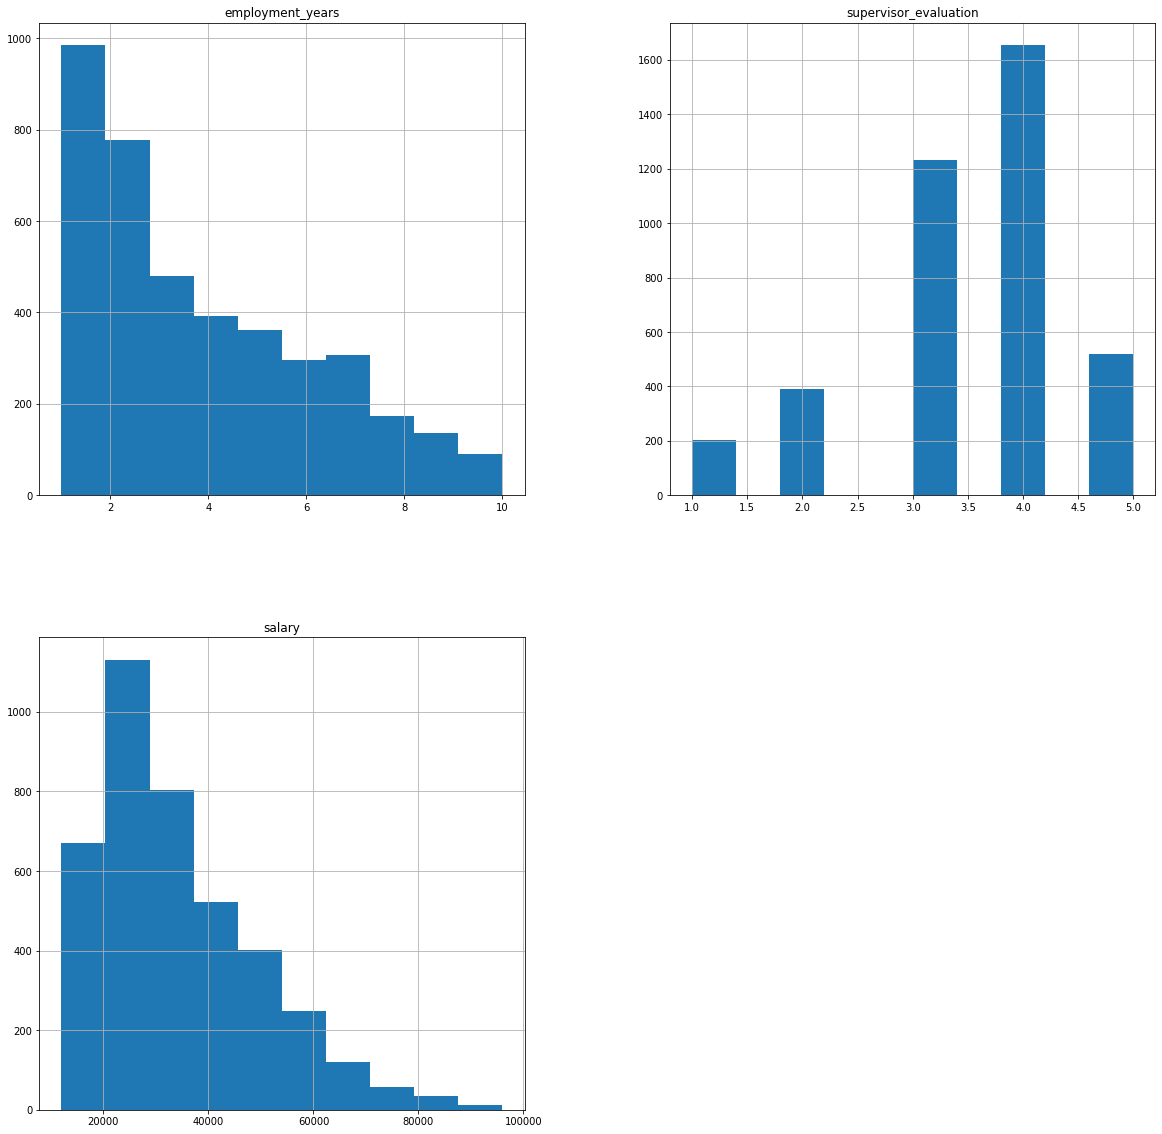

In [65]:
train_quit.drop('id', axis = 1).hist(figsize = (20,20))
plt.show()

По данным гистограммам можем пронаблюдать отсутсвие аномалий

#### Выводы по разделу

Датафреймы, используемые для данной задачи, не отличаются или незначительно отличаются от датафреймов из начала работы, поэтому многие выводы оказались аналогичны предыдущим датафреймам

Датафреймы были проверены на чистоту данных и готовы к EDA и дальнейшей подготовке для моделей

### Исследовательский анализ данных

#### Количественные признаки

##### train_quit

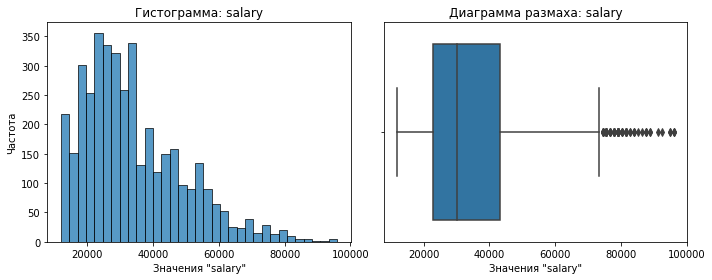

In [66]:
numeric_quit = ['salary']
categorial_quit = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
target = 'quit'

for col in numeric_quit:
    hist_and_boxplot(train_quit, col)

##### test_features

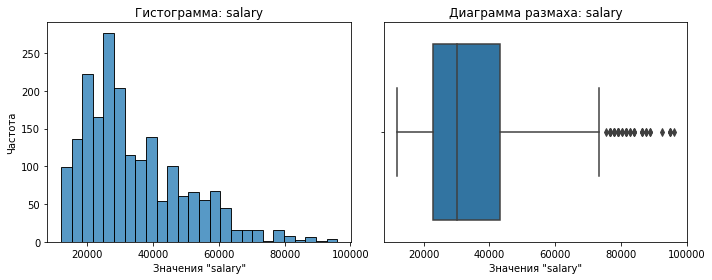

In [67]:
for col in numeric_quit:
    hist_and_boxplot(test_features, col)

Все количественные признаки соответствуют выводам полученным в первой части данной работы. Явных аномалий нет, распределения логнормальные, что свойственно для зарплат

#### Категориальные признаки

##### train_quit

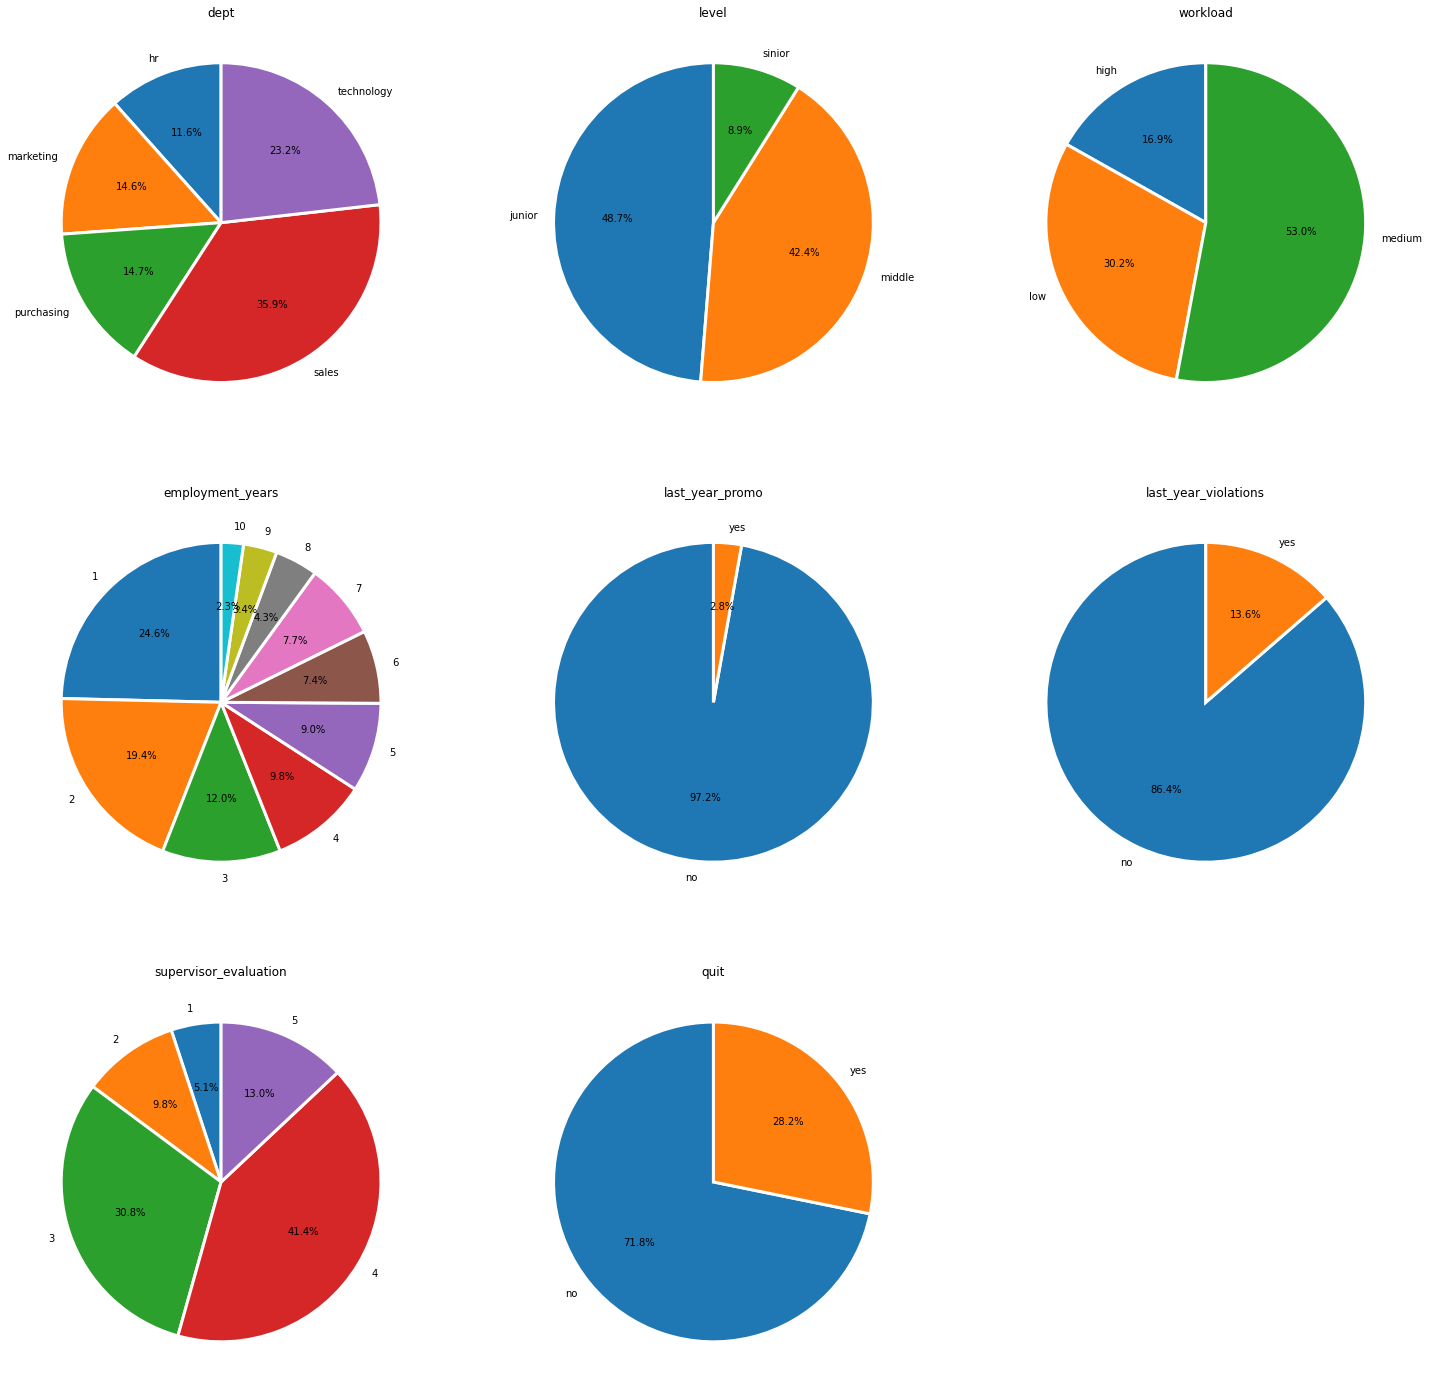

In [68]:
i=1
plt.figure(figsize=(25,25))
for cols in categorial_quit:
    pie(train_quit, cols, 3,3, i)
    i+=1
pie(train_quit, target, 3,3, i)

В данном датафрейме все категоральные и дискретные признаки соответсвуют выводам из первого раздела, важно лишь добавить, что quit распределен следующим образом:
* 71,8% - сотрудники, не покинувшие организации
* 28,2% - сотрудники, покинувшие свои компании

##### test_features

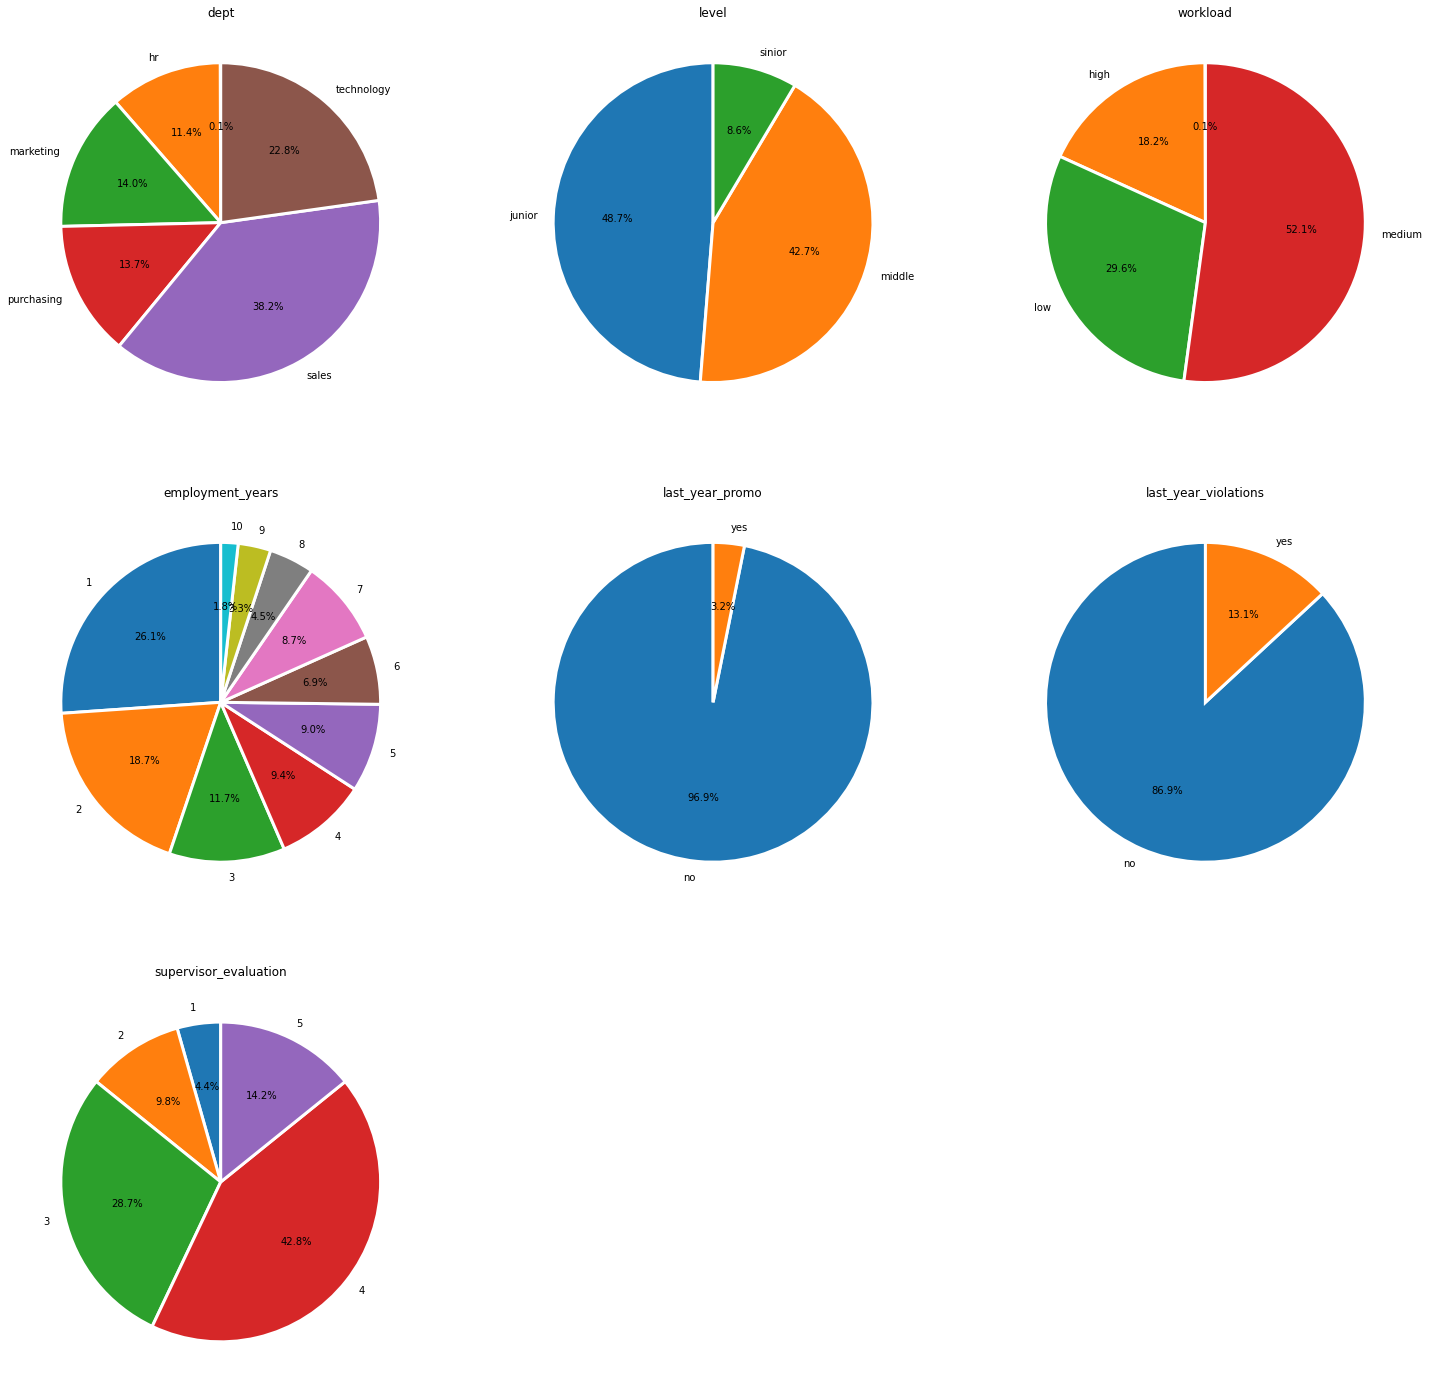

In [69]:
i=1
plt.figure(figsize=(25,25))
for cols in categorial_quit:
    pie(test_features, cols, 3,3, i)
    i+=1

Выводы по всем категориальным признакам схожи с выводами из певрой части задачи

#### Портрет "уволившегося сотрудника"

In [70]:
liquidated = train_quit.query('quit == "yes"')
stayed = train_quit.query('quit == "no"')

liquidated.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1128.0,544544.457447,258059.498361,100222.0,325073.0,545003.5,756296.0,999158.0
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


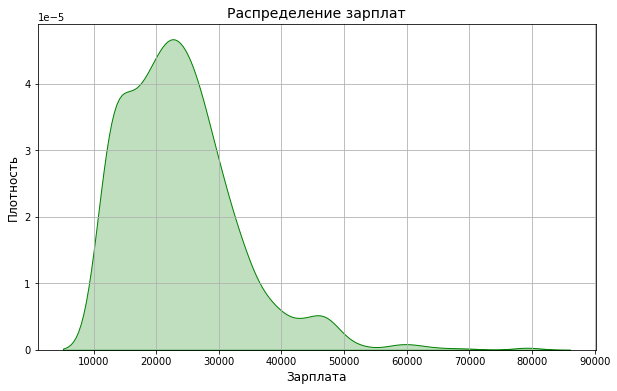

In [71]:
plt.figure(figsize=(10, 6))
sns.kdeplot(liquidated['salary'], color='green', linewidth=1, fill=True)
plt.title('Распределение зарплат', fontsize=14)
plt.xlabel('Зарплата', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.grid()
plt.show()

На данном этапе мы рассмотрели распределение зарплат у увольняющихся сотрудников, наложим также распределение зарплат остающихся сотрудников для сравнения (может быть влияние зарплаты очень велико)

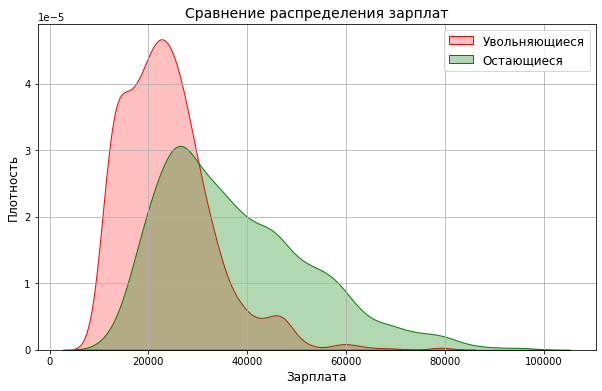

In [72]:
plt.figure(figsize=(10, 6))
sns.kdeplot(liquidated['salary'], color='red', linewidth=1, fill=True, label='Увольняющиеся')
sns.kdeplot(stayed['salary'], color='green', linewidth=1, fill=True, alpha=0.3, label='Остающиеся')
plt.title('Сравнение распределения зарплат', fontsize=14)
plt.xlabel('Зарплата', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

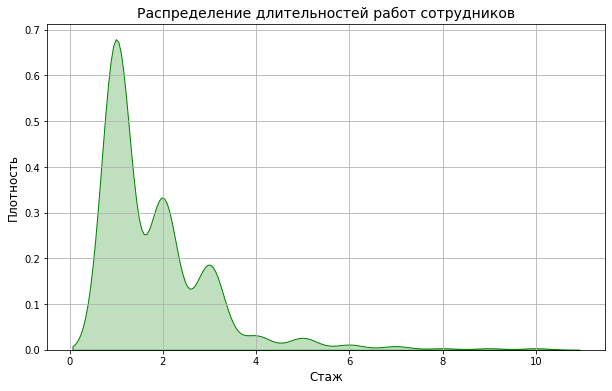

In [73]:
plt.figure(figsize=(10, 6))
sns.kdeplot(liquidated['employment_years'], color='green', linewidth=1, fill=True)
plt.title('Распределение длительностей работ сотрудников', fontsize=14)
plt.xlabel('Стаж', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.grid()
plt.show()

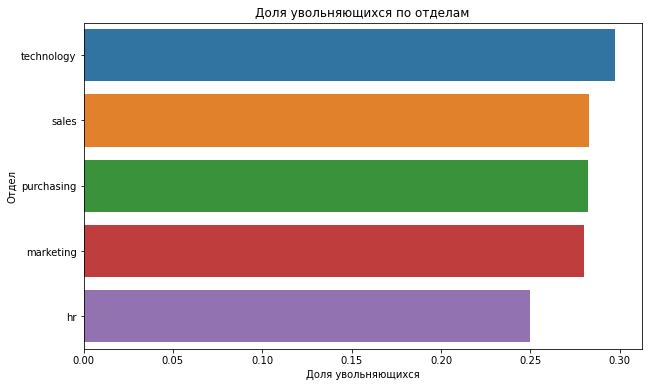

In [74]:
quit_rates = train_quit.groupby(['dept'])['quit'].value_counts(normalize=True).unstack()

quit_rates = quit_rates['yes'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=quit_rates.values, y=quit_rates.index)
plt.title('Доля увольняющихся по отделам')
plt.xlabel('Доля увольняющихся')
plt.ylabel('Отдел')
plt.show()

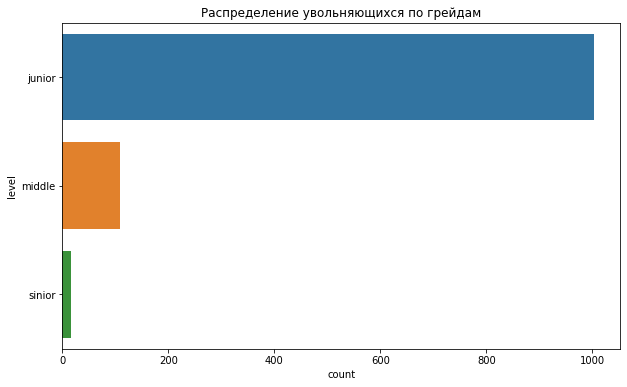

In [75]:
plt.figure(figsize=(10, 6))
sns.countplot(data=liquidated, y='level', order=liquidated['level'].value_counts().index)
plt.title('Распределение увольняющихся по грейдам')
plt.show()

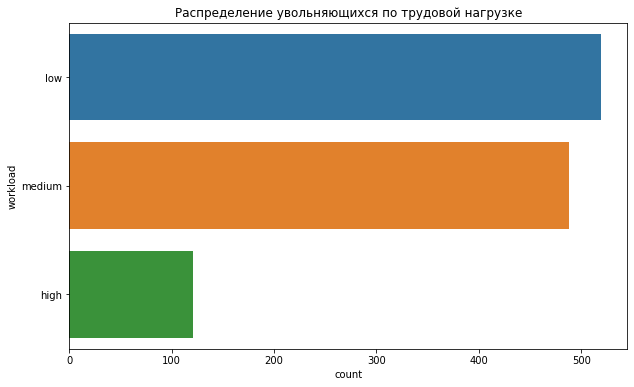

In [76]:
plt.figure(figsize=(10, 6))
sns.countplot(data=liquidated, y='workload', order=liquidated['workload'].value_counts().index)
plt.title('Распределение увольняющихся по трудовой нагрузке')
plt.show()

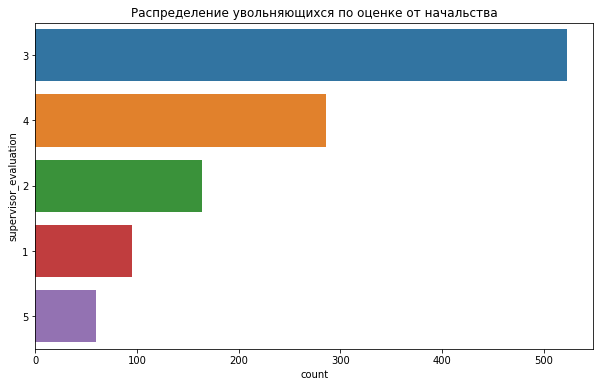

In [77]:
plt.figure(figsize=(10, 6))
sns.countplot(data=liquidated, y='supervisor_evaluation', order=liquidated['supervisor_evaluation'].value_counts().index)
plt.title('Распределение увольняющихся по оценке от начальства')
plt.show()

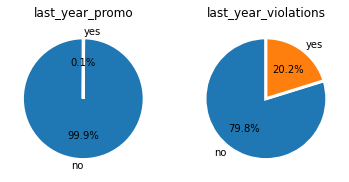

In [78]:
pie(liquidated, 'last_year_promo', 1, 2, 1)
pie(liquidated, 'last_year_violations', 1, 2, 2)

**Портрет типичного увольняющегося сотрудника**

* **Зарплатные характеристики**
 - **Средняя зарплата**: 23 885 руб. (значительно ниже медианы рынка)
 - **Зарплатное распределение**: Большинство увольняющихся получают 15 000-25 000 руб., что заметно меньше остающихся сотрудников


* **Стаж и опыт работы**
 - **Средний стаж**: 1,84 года (менее 2 лет)
 - **Критический период**: Пик увольнений приходится на первый год работы


* **Департаментальное распределение**
1. Technology (IT) - максимальная доля увольнений (~30%)
2. Sales (продажи) - второе место по доле увольнений (~29%)
3. Purchasing (закупки) - третье место (~28%)
**Разница между отделами относительно небольшая (5 процентных пунктов)**


* **Должностной уровень**
 - **Junior-специалисты** составляют подавляющее большинство увольняющихся (~1000 из ~1128)
 - **Middle-специалисты** - минимальные увольнения (~100 человек)
 - **Senior-специалисты** - единичные случаи (~20 человек)


* **Рабочая нагрузка - Парадоксальная ситуация:**
 - **Низкая нагрузка (low)** - ~500 увольнений
 - **Средняя нагрузка (medium)** - ~480 увольнений  
 - **Высокая нагрузка (high)** - всего ~150 увольнений


* **Оценки руководства**
 - **Средняя оценка**: 3,05 балла из 5 (низкая)


* **Дополнительные факторы**
 - **Повышения**: 99,9% не получали повышения в прошлом году




**Критические проблемы:**
1. **Неконкурентная оплата труда** - основная причина увольнений
2. **Слабая адаптация новых сотрудников** (высокий отток в первый год)
3. **IT-отдел требует первоочередного внимания** как лидер по оттоку, но в целом проблемы затрагивают все отделы - разница в долях увольнений невелика
4. **Недостаточная мотивация junior-специалистов**

**Парадоксы, требующие внимания:**
- Сотрудники с низкой нагрузкой увольняются чаще (возможно, из-за недозагруженности и отсутствия развития)
- Практически никто не получает повышений, что демотивирует персонал

#### Влияние удовлетворенности на увольнение

Для начала добавим job_satisfaction_rate из первой части задачи в test_features. А также соединим test_features с test_target_quit, чтобы убедиться, что признаковые описания представлены для всех тестовых пользователей

In [79]:
test_features = test_features.merge(test_target_jsr, on='id', how='right')
test_features = test_features.merge(test_target_quit, on='id', how='left')

quit = test_features[test_features['quit'] == 'yes']['job_satisfaction_rate']
stayed = test_features[test_features['quit'] == 'no']['job_satisfaction_rate']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,130604,technology,junior,medium,1,no,no,4,34800,0.74,no
1,825977,marketing,middle,high,7,no,no,5,58800,0.75,no
2,418490,purchasing,junior,low,1,no,no,4,19200,0.60,yes
3,555320,technology,junior,medium,1,no,no,4,34800,0.72,no
4,826430,technology,junior,medium,1,no,yes,2,30000,0.08,yes


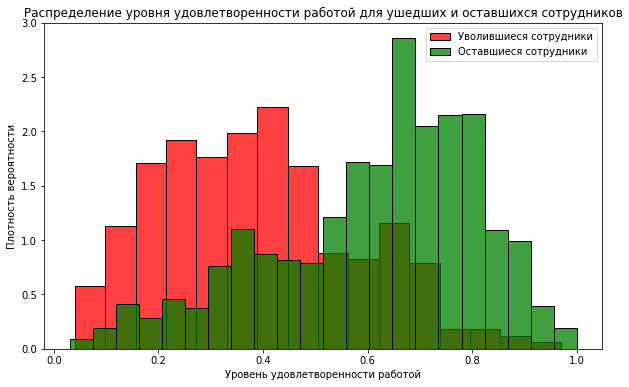

In [80]:
display(test_features.head())
plt.figure(figsize=(10, 6))
sns.histplot(quit, color='red', label='Уволившиеся сотрудники', stat='density')
sns.histplot(stayed, color='green', label='Оставшиеся сотрудники', stat='density')

plt.legend()
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность вероятности')
plt.title('Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников')
plt.show()

**Ключевые наблюдения:**

**Увольняющиеся сотрудники (красные столбцы):**
- **Концентрация в зоне низкой удовлетворенности** (0.1-0.5)
- **Пик распределения** приходится на уровень 0.4-0.45
- **Практически отсутствуют** в зоне высокой удовлетворенности (0.7-1.0)
- **Средний уровень удовлетворенности** явно ниже 0.5

**Остающиеся сотрудники (зеленые столбцы):**
- **Концентрация в зоне высокой удовлетворенности** (0.6-0.8)
- **Максимальный пик** на уровне 0.7
- **Минимальное присутствие** в зоне низкой удовлетворенности
- **Средний уровень** явно выше 0.6



**Гипотеза ПОДТВЕРЖДЕНА** - уровень удовлетворенности работой является **критическим предиктором** увольнения.


**Практические выводы:**

1. **Система раннего предупреждения**: Сотрудники с satisfaction_rate < 0.5 требуют немедленного внимания HR

2. **Профилактические меры**: 
   - Регулярные опросы удовлетворенности
   - Индивидуальные беседы с сотрудниками в зоне риска
   - Программы повышения engagement

3. **Retention-стратегия**: Фокус на повышении удовлетворенности до уровня 0.6+ для критической массы сотрудников

Этот график окончательно подтверждает, что **неудовлетворенность работой** является основным драйвером увольнений, даже более важным чем зарплата или стаж.

#### выводы по разделу

1. **Количественные признаки**
   Распределение зарплат в выборках `train_quit` и `test_features` логнормальное, без аномалий. Это подтверждает корректность данных и соответствует типичному виду распределения заработных плат.


2. **Категориальные признаки**
   Распределения категориальных и дискретных признаков в `train_quit` и `test_features` соответствуют ожиданиям и ранее сделанным выводам. Признак `quit` имеет сильный дисбаланс: 71.8% сотрудников остались, 28.2% уволились.


3. **Портрет уволившегося сотрудника**

   * **Зарплата:** Средняя — 23 885 руб., что значительно ниже медианной по выборке. Большинство увольняющихся получали 15 000–25 000 руб.
   * **Стаж:** Средний стаж — 1.84 года. Пик увольнений — в первый год работы.
   * **Департамент:** Наибольшее число увольнений в отделах Sales, Technology и Purchasing.
   * **Грейд:** Подавляющее большинство увольняющихся — junior-специалисты.
   * **Нагрузка:** Чаще увольняются сотрудники с низкой и средней нагрузкой, что может говорить о недостаточной вовлечённости или карьерной стагнации.
   * **Оценка начальства:** Средняя — 3.05 из 5, что указывает на невысокую оценку со стороны руководства.
   * **Повышения:** 99.9% увольнявшихся не получали повышения в прошлом году.


4. **Влияние удовлетворенности работой**
- Сотрудники с низким уровнем job satisfaction (особенно < 0.5) значительно чаще увольняются. В отличие от них, остающиеся имеют пиковые значения удовлетворенности на уровне 0.7. Это делает показатель job\_satisfaction\_rate наиболее сильным предиктором увольнения.

### Добавление удовлетворенности как еще одного входного признака

Добавим в тренировочную выборку предсказанное значение удовлетворенности работой

In [81]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)

test_features['job_satisfaction_rate'] = best_model.predict(test_features.drop('job_satisfaction_rate', axis =1))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [83]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,130604,technology,junior,medium,1,no,no,4,34800,0.690,no
1,825977,marketing,middle,high,7,no,no,5,58800,0.815,no
2,418490,purchasing,junior,low,1,no,no,4,19200,0.670,yes
3,555320,technology,junior,medium,1,no,no,4,34800,0.690,no
4,826430,technology,junior,medium,1,no,yes,2,30000,0.180,yes


### Подготовка данных

**Стратегия предобработки признаков:**
1. Категориальные признаки:
 * OneHotEncoder: dept, last_year_promo, last_year_violations — номинальные признаки без естественного порядка
 * OrdinalEncoder: level, workload — порядковые признаки с иерархической структурой

2. Количественные признаки:
 * Масштабирование: employment_years, salary, supervisor_evaluation с обработкой пропущенных значений в пайплайне

3. Целевая переменная:
 * LabelEncoder: бинарное кодирование признака quit

**Техническая реализация:**
Применяем существующий пайплайн data_preprocessor из задачи прогнозирования удовлетворенности, дополнив его специфичными для задачи увольнений преобразованиями. Данный подход обеспечивает консистентность предобработки и воспроизводимость результатов.

In [84]:
ohe_columns = [
   'dept',
    'last_year_promo',
    'last_year_violations'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate']

In [85]:
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']
X_test = test_features.drop('quit', axis=1)
y_test = test_features['quit']


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)



pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
])

### Обучение моделей

Обучим 5 моделей и подберем гиперпараметры для них. Проверим качество лучшей модели.

Метрика оценки качества в этой задаче — ROC-AUC. Цель — достичь значения ROC-AUC ≥ 0.91 на тестовой выборке.

In [86]:
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 150], 
        'models__max_depth': range(5, 8),
        'models__max_features': range(5, 8), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 5),
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [87]:
search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose = 2
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=5, models__max_features=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.3s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=5, models__max_features=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.3s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=5, models__max_features=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.3s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=5, models__max_features=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   0.3s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=5, models__max_features=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   0.3s
[CV] END models=RandomFore

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': [0.01, 0.1, 1, 10],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='poly', random_state=42)],
                          'models__C': [0.1, 1, 10],
                          'models__degree': range(2, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc', verbose=2)

In [88]:
results_df = pd.DataFrame(search.cv_results_)
top_10 = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

print('Топ-10 моделей по кросс-валидации:\n')
display(top_10[['params', 'mean_test_score', 'rank_test_score']])

Топ-10 моделей по кросс-валидации:



,params,mean_test_score,rank_test_score
36,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': StandardScaler()}",0.938475,1
38,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': 'passthrough'}",0.938427,2
37,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': MinMaxScaler()}",0.938378,3
39,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 150, 'preprocessor__num': StandardScaler()}",0.938370,4
41,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 150, 'preprocessor__num': 'passthrough'}",0.938330,5
40,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 7, 'models__max_features': 5, 'models__n_estimators': 150, 'preprocessor__num': MinMaxScaler()}",0.938258,6
20,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': 'passthrough'}",0.938175,7
18,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': StandardScaler()}",0.938164,8
19,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 5, 'models__n_estimators': 100, 'preprocessor__num': MinMaxScaler()}",0.938147,9
27,"{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 6, 'models__n_estimators': 150, 'preprocessor__num': StandardScaler()}",0.938087,10


Проверим также модель на тестовых данных и сравним с константной моделью для прямого отображения эффективности и полезности полученного алгоритма

In [89]:
y_pred_proba = search.predict_proba(X_test)
roc_auc_model = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'Метрика ROC-AUC на тестовой выборке (лучшая модель): {round(roc_auc_model, 4)}')

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict_proba(X_test)
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy[:, 1])
print(f'Метрика ROC-AUC на тестовой выборке (константная модель): {round(roc_auc_dummy, 4)}')

if roc_auc_model > roc_auc_dummy:
    print('Модель лучше константной, разница в ROC-AUC:', round(roc_auc_model - roc_auc_dummy, 4))
else:
    print('Константная модель превосходит текущую модель, разница в ROC-AUC:', round(roc_auc_dummy - roc_auc_model, 4))

Метрика ROC-AUC на тестовой выборке (лучшая модель): 0.9321
Метрика ROC-AUC на тестовой выборке (константная модель): 0.4938
Модель лучше константной, разница в ROC-AUC: 0.4383


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Выводы по разделу

На данном этапе было выполнено обучение и подбор гиперпараметров для пяти моделей: RandomForestClassifier, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC.


**В результате кросс-валидации была найдена лучшая модель с параметрами:**
{'preprocessor__num': 'passthrough',
 'models__n_estimators': 100,
 'models__max_features': 5,
 'models__max_depth': 7,
 'models': RandomForestClassifier(random_state=42)}
 
 
Метрика лучшей модели на кросс-валидации: 0.9385
Метрика ROC-AUC на тестовой выборке: 0.932


Для сравнения, метрика ROC-AUC константной модели составила 0.4938, что подтверждает значительное превосходство оптимизированной модели над базовым подходом.

**Таким образом, модель RandomForestClassifier показала отличные результаты и значительно превысила целевое значение ROC-AUC ≥ 0.91 на тестовой выборке.**

## Выводы

**Результаты решения задач**

1. **Задача 1:**
* Модель `DecisionTreeRegressor` показала наилучшие результаты в прогнозировании уровня удовлетворенности работой (`SMAPE` = 14.28%). Эффективность модели обусловлена оптимальным подбором гиперпараметров (max_depth=13, max_features=11) и корректной подготовкой данных с правильным объединением признаков и целевой переменной.

2. **Задача 2:**
* Случайный лес `RandomForestClassifier` продемонстрировал наилучшие результаты в прогнозировании увольнения сотрудников (`ROC-AUC` = 0.934 на тестовых данных). Успех модели связан с оптимальной настройкой параметров (n_estimators=100, max_depth=7, max_features=5) и высокой устойчивостью к переобучению.

**Ключевые выводы**

Стабильность разработанных моделей подтверждается минимальной разностью между результатами кросс-валидации и тестирования, что свидетельствует об отсутствии переобучения и высокой надежности прогнозов.

Обе модели значительно превзошли поставленные целевые показатели качества (SMAPE < 15% и ROC-AUC ≥ 0.91 соответственно), что демонстрирует эффективность примененного подхода к решению задач.

Уровень удовлетворенности работой является одним из ключевых факторов, влияющих на вероятность увольнения сотрудников, что подтверждается высокими результатами прогнозирования в обеих задачах.


**Дополнительные предложения для бизнеса**
1. Работа с зарплатной политикой:

 * Пересмотр систем оплаты труда для сотрудников с зарплатой ниже 25 000 руб., особенно в департаментах Sales, Technology и Purchasing
 * Внедрение более справедливой системы компенсаций, учитывающей рыночные стандарты

2. Программы адаптации и развития:

 * Усиление программ адаптации новых сотрудников в первый год работы, когда риск увольнения максимален
 * Создание четких карьерных траекторий для junior-специалистов с конкретными этапами развития
 * Внедрение системы регулярных повышений и ротации для предотвращения карьерной стагнации

3. Управление нагрузкой и вовлеченностью:

 * Пересмотр распределения рабочей нагрузки для сотрудников с низкой и средней загрузкой
 * Создание дополнительных проектов и инициатив для повышения вовлеченности недозагруженных сотрудников
 * Внедрение системы ментворства для повышения мотивации и профессионального развития

4. Работа с руководителями:

 * Обучение менеджеров эффективному управлению командой и объективной оценке подчиненных
 * Внедрение системы 360-градусной обратной связи для улучшения качества оценки сотрудников

5. Технические решения

 * Внедрение системы мониторинга уровня удовлетворенности работой сотрудников с использованием разработанной модели регрессии
 * Использование модели RandomForestClassifier для прогнозирования рисков увольнения сотрудников и разработки проактивных мер по их удержанию

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Никита, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
Выводы и рассуждения получились содержательными, их было интересно читать.
</font>

<font color='steelblue'>Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.

Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)

Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.

Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)</font>

<font color='blue'><b>Жду твой проект на повторном ревью. До встречи :) </b></font>

<font color='blue'><b>Итоговый комментарий ревьюера 2</b></font>\
<font color='green'>Никита, большое спасибо за доработку.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Не подстраивай модели под тестовые данные.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='darkorange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>

<font color='blue'><b>Итоговый комментарий ревьюера 3</b></font>\
<font color='green'> Никита, проект принят! \
Все этапы пройдены. Все рекомендации учтены.\
Надеюсь, тебе понравился процесс выполнения и результат.</font> \
<font color='blue'><b>Спасибо, удачи в освоении профессии!</b></font>